## Introduction

Previously, we looked at fungal leucine tRNAs in GtRNAdb. Next, we're going to look at all eukaryotic leucine tRNAs in GtRNAdb. This will involve two extra steps. I'll need to build a phylogenetic tree, which will be used for autodetection of identity elements. This will replace the hardcoded yeast IDEs. 

We've learned that in fungi, the lower bound for _percentage of tRNAs missing an IDE_ is 20% in a single species, while every single species contained at least one tRNA with the proper IDEs. So for autodetection of IDEs, what can we set as a cutoff? What if all but one species has the IDEs? This could mean that the one species has a mutated synthetase. We need to set a boundary for the amount of evidence that will convince us that a conserved position is an identity element. I'd say that if 80% of species within a clade have the IDE in at least one tRNA, then it's convincing. 

## Workflow
One potential workflow is as follows:
1. Generate multi-tiered phylogenetic tree
2. Align and filter tRNAs from each clade
3. For each clade, find and score potential IDEs.
    - This includes base pairs and single bases.
    - Scoring will need to take into account a) number of species with at least one tRNA with the IDE, and b) percent of tRNAs with the IDE within each species. (a) is a scalar, while (b) is a vector. So we'll take the product of (a) and the mean of (b), for a score between 0 and 1. Let $s$ be the number of subclades in the clade, while $s_i$ is the subset of subclades containing at least one tRNA with an IDE $i$. $s$ can refer to species (e.g. _S. cerevisiae_ within fungi) or clades (e.g. fungi within eukaryotes). Let $t_s$ be the number of tRNAs within a subclade $s$, and $t_i$ be the number of tRNAs containing an IDE $i$. Then: 
$$\text{Score} = \frac{s_i}{s}\frac{\sum^s{t_{s,i}}}{s}$$
    - As a heuristic, we will not score any positions with $s_i < 0.8$.
4. Imagine a phylogenetic tree with root R branching into clades A, B, and C. If steps #2-#4 are performed for each of A, B, and C, we will now want to perform a R-wide analysis of the IDEs identified within subclades A, B, and C. Since this IDE analysis is entirely computational, some phylogenetic context is necessary. Then, we will want to perform a t-test for the scores of each IDE, between R and A (or B or C). The null hypothesis is that they are the same, e.g. conserved. 
    - Alternatively, we can assume that positions without evolutionary pressure have scores that follow a normal distribution, with a mean of $0.25 \cdot 0.25 = 0.0625$. But tRNAs are subject to a variety of compounding pressures, and have different evolutionary timelines, so actually, this is a silly assumption.
    - Either way, we will need to apply multiple testing corrections.
    
Unfortunately, this would fail in the case where the same position is mutated among different clades - for example, maybe fungi have A35 while mammals have G35. This requires a positional analysis. Instead of counting the number of tRNAs with an IDE, we can look at the R-wide information content. In theory, low information content means conservation. 

Given a method for finding positional IDE information, we should start with a list of positional IDEs, then try to resolve nucleotides. This also eliminates the need for subclade IDE autodetection, and instead we can just take the base or nucleotide at the proper position. So, we'll need to develop a cutoff for entropy. This would be used to determine the position of the base. Then we'd have to figure out a clade-wide nucleotide, which also needs a cutoff. I'm not too worried about this second cutoff, since we can just say something like 80%, and reanalyze subclades - the important thing is the entropy of the position. 

## Revised workflow
1. Generate multi-tiered phylogenetic tree
2. Align and filter tRNAs from each clade
3. **Find positions under entropy cutoff**
4. Resolve nucleotides corresponding to positions, if possible.
5. Resolve nucleotides for subclades.

In this notebook, I'll be performing this analysis for eukaryotic leucine tRNAs in order to find an appropriate entropy cutoff. Leucine is a good system since it is well studied, and has shared as well as differing IDEs between yeast and human. 

Later, we will want to look at identity element "suites" - what combinations of identity elements can be persistently found throughout a clade? This would be able to match the brain-specific arginine across species.

### Yeast/human leucine IDEs
Shared     |Yeast    |Human           |
:--------|---------|-----------------:
A73      |G35, G37 |C3:G70, A4:U69, G5:C68, C20a

We have a couple of options for determining entropy.

First, we can parse the alignment itself. For example, there are 925 As, 4 Us, and 21 Gs at position 73. There are also 2 Ns and 2 '-'s, which we don't count. Average entropy here is

$$-\sum^np_i\log_2{p_i}$$

In [2]:
from math import log2
-925/950*log2(925/950) - 4/950*log2(4/950) - 21/950*log2(21/950)

0.19225738255857028

Now if we look at position 69, this is the entropy you'd see from a typical position.

In [3]:
# 184 As, 36 Gs, 426 Us, 289 Cs
184+36+426+289

935

In [4]:
def entropy(n, total): return -n/total*log2(n/total)
entropy(184, 935) + entropy(36, 935) + entropy(426, 935) + entropy(289, 935)

1.6827342976356228

I thought about building a covariance model and parse the file to get emission log-odds bit scores for each possible nucleotide or base pair. This is different from what I calculated above: odds and probability are different. 

It's not clear how to consolidate log-odds into single positional scores. Range is loosely correlated with conservation for strong IDEs, but what if we had a subclade mutate the base at that position? Then for the position, we'd see a smaller range of bit scores, and it would be indistinguishable from variation. Overall, not being able to resolve multiple log odds scores into a scalar is probably because the range of possible odds is [0, $\infty$]. Unlike probabilities, which sum to 1, odds are unbounded. What we could do is recover the probabilities by taking the root inverse log. Then we can aggregate them using the above process.

But that would take too long, and we're trying to get a move on here. We'll stick with the former, finding positions with minimum entropy. 

## Parse alignment into positions

We'll come back to building a phylogenetic tree later. First, we'll get the entropy at each position and see if there's an easy cutoff. We use the R2 alignment used to build the leucine-specific CM, and also just the fungal tRNAs. Again, we use `--matchonly` to get the proper numbering, and ignore potential insertions/deletions.

In [5]:
%%bash
cp ../gtrnadb-fungi/fungi-Leu-tRNAs.sto .
cp ../../tRNAscan/models/1.6/fasta/euk-Leu-r2-031616.fa euk-Leu.fa
cmalign -g --notrunc --matchonly -o euk-Leu.sto /projects/lowelab/users/blin/tRNAscan/models/current/TRNAinf-euk-Leu.cm euk-Leu.fa > /dev/null

We need to dynamically determine what the secondary structure looks like. I use a combination of Sprinzl numbering and region numbering to track positions, since there are some weird tRNAs out there (variable loop, long D arm/D loop, G0, etc).

This section has been moved to `../tRNA_position.py`.

In [89]:
from tRNA_position import get_positions

position = get_positions('euk-Leu.sto')

## Determine entropy cutoff

Okay, all the data is processed and in place. Let's convert it into a data frame and plot it.

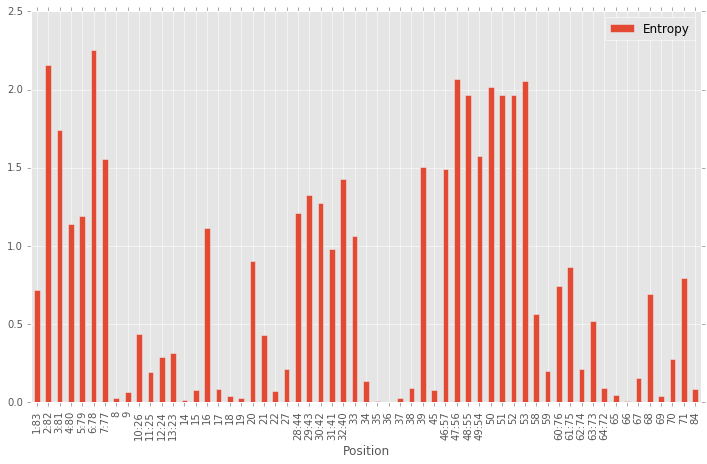

In [51]:
df = pd.concat(pd.DataFrame({'Position': [position.position], 
                              'Entropy': [position.entropy]}) for position in positions)

df.plot(kind='bar', x='Position')

The identity elements in question are listed here again:

Numbering  | Shared     |Yeast    |Human           |
:--------|---------|---------|---------------------------:
 Sprinzl |A73      |G35, G37 |C3:G70, A4:U69, G5:C68, C20a
 Isotype-specific | 84   | 35, 37   | 3:81, 4:80, 5:79, none


Unfortunately, we can't see data for the human C20a insertion. 

Let's run this analysis for fungi only, and also for all mammals.


In [56]:
%%bash
grep "Mammalia" /projects/lowelab/users/blin/identity/gtrnadb-fungi/genome_table_20151017.txt | egrep -v "bosTau7|hg38|mm9" > gtrnadb-mammalia.txt

In [76]:
def create_mammalian_alignment():
  import subprocess
  from Bio import SeqIO
  species = []
  for line in open('gtrnadb-mammalia.txt'):
      tabs = line.strip().split('\t')
      if len(tabs[1]) > 2: species.append(tabs[1])
  leu_fhandle = open('mam-Leu-tRNAs.fa', 'w')
  for seq in SeqIO.parse('euk-Leu-r2-031616.fa', 'fasta'):
      if ("Leu" in seq.name) and any(s in seq.name for s in species):
          SeqIO.write(seq, leu_fhandle, 'fasta')
  leu_fhandle.close()

  subprocess.call('cmalign -g --notrunc --matchonly -o mam-Leu-tRNAs.sto /projects/lowelab/users/blin/tRNAscan/models/current/TRNAinf-euk-Leu.cm mam-Leu-tRNAs.fa', shell = True)

create_mammalian_alignment()
mam_positions = get_positions('mam-Leu-tRNAs.sto')

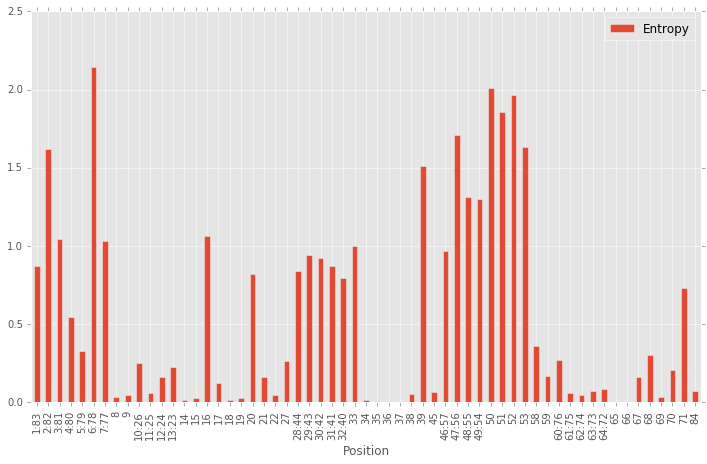

In [77]:
df = pd.concat(pd.DataFrame({'Position': [position.position], 
                              'Entropy': [position.entropy]}) for position in mam_positions)

df.plot(kind='bar', x='Position')

In [85]:
for position in mam_positions: 
  print(position)
  print(', '.join('{}:{}'.format(key, value) for key, value in position.counts.items()))
  print('Entropy: {}\n'.format(position.entropy))

Position 1:83 (acceptor #1)
G:C:580, -:C:1, A:C:4, G:N:1, C:C:1, A:U:142, G:U:5, -:-:1
Entropy: 0.8695990742097626

Position 2:82 (acceptor #2)
U:G:3, G:C:239, C:G:142, G:A:1, G:N:1, C:A:1, A:U:2, A:A:1, U:A:344, -:-:1
Entropy: 1.618251839456041

Position 3:81 (acceptor #3)
U:G:242, G:G:1, C:G:483, C:A:2, A:G:1, -:A:1, U:A:4, -:-:1
Entropy: 1.0416893602704882

Position 4:80 (acceptor #4)
G:C:61, C:U:1, A:C:4, -:-:1, A:U:664, G:U:2, U:U:2
Entropy: 0.5436396778112177

Position 5:79 (acceptor #5)
G:A:2, G:C:700, A:U:2, A:C:3, G:U:28
Entropy: 0.32539825795174515

Position 6:78 (acceptor #6)
U:G:18, G:C:203, C:G:188, U:A:34, C:A:1, A:G:1, -:U:1, A:U:35, G:U:253, U:U:1
Entropy: 2.142579267039109

Position 7:77 (acceptor #7)
G:G:1, G:C:238, A:C:1, C:C:1, A:U:487, A:A:1, G:U:5, U:U:1
Entropy: 1.0339757653348451

Position 8 (single #1)
U:733, G:1, C:1
Entropy: 0.029829471693680287

Position 9 (single #2)
U:1, A:2, G:732
Entropy: 0.04201910418097976

Position 10:26 (dstem #1)
G:A:2, G:C:711, G:G

In [88]:
mean(position.entropy for position in mam_positions) # mean entropy

0.5625347617839733

We have a problem.

Some cases are very clearly identity elements. For example:

```
Position 84 (single #1)
N:1, A:730, G:2, C:1, -:1
Entropy: 0.07183249788673751
```

There is universal agreement, aside from a few exceptions (those are worth looking into later...!!!). But what about positions like this?

```
Position 16 (dloop #3)
U:389, A:3, G:3, C:340
Entropy: 1.0651197030015849
```

This has a much higher entropy, higher than the average entropy. So maybe entropy isn't a good measure for position. It becomes painfully clear with base pairs. For example, the known IDE at 3:70:

```
Position 3:81 (acceptor #3)
U:G:242, G:G:1, C:G:483, C:A:2, A:G:1, -:A:1, U:A:4, -:-:1
Entropy: 1.0416893602704882
```

Looking at the alignments, it seems like U:G and C:G are evenly distributed throughout all mammals. But it wouldn't get picked up by a pure entropy cutoff. 

## Frequency cutoffs

Instead of an entropy cutoff, I can use a frequency cutoff instead. This would encompass all of the _negative_ identity elements, too. Identity elements are defined as existing in at least 90% of tRNAs.

Here's a table of the possible positions, including base pairs, aside from ACGTN. "Rank" refers to the precedence of the rule - for example, a position that has 91% As and 9% Us will be determined to be an "A", and not "W". More specific rules are evaluated first, in a greedy fashion.

Base pairing rules involving mismatches are kept to a minimum. The assumption is that a position inside a stem is typically supposed to be a base pair. There are instances of steric hindrance due to mismatches; however, those are not well known and I'd like to avoid over-annotating lesser known phenomena.

Symbol   |   Bases  | Rule  | Rank
:--------|----------|-------|------
R | G A | Purine | 2
Y | U C | Pyrimidine | 2
K | G U | Keto | 2
M | A C | Amino | 2
S | G C | Strong | 2
W | A U | Weak | 2
B | C G U | not A | 3
D | G A U | not C | 3
H | A C U | not G | 3
V | G C A | not U | 3
R:Y | G:C A:U | Purine-Pyrimidine | 2
Y:R | C:G U:A | Pyrimidine-Purine | 2
S:S | G:C C:G | Strong | 2
W:W | A:U U:A | Weak | 2
W:O | G:U U:G | Wobble | 2
B:V | G:C C:G U:A | not A:U | 3
V:B | G:C C:G A:U | not U:A | 3
D:H | A:U U:A G:C | not C:G | 3
H:D | A:U U:A C:G | not G:C | 3
W:C | A:U U:A G:C C:G | Watson-Crick | 4
G:N | G:C G:U C:G U:G | G | 5
U:N | U:G U:A A:U G:U | U | 5
C:O | A:U U:A G:C C:G G:U U:G | Canonical pairs | 6
Y:Y | U:C C:U U:U C:C | Pyrimidine-pyrimidine mismatch | 7
R:R | A:G G:A A:A G:G | Purine-purine mismatch | 7
M:M | A:A G:G C:C U:U A:G A:C C:A C:U G:A U:C | Mismatch | 8

Now, I need to determine the dominant base or base pair at each position. These may not necessarily reflect real identity elements.

In [160]:
def position_generator(positions, threshold=0.95):
  for position in positions: # iterate through positions
    if position.paired:
      combos = [{'A:U': ['A:U'], 'U:A': ['U:A'], 'G:C': ['G:C'], 'C:G': ['C:G'], 'G:U': ['G:U'], 'U:G': ['U:G'], 'A:A': ['A:A'], 'C:C': ['C:C'], 'G:G': ['G:G'], 'U:U': ['U:U'], 'A:G': ['A:G'], 'G:A': ['G:A'], 'A:C': ['A:C'], 'C:A': ['C:A'], 'C:U': ['C:U'], 'U:C': ['U:C']},
                {'R:Y': ['G:C', 'A:U'], 'Y:R': ['C:G', 'U:A'], 'S:S': ['G:C', 'C:G'], 'W:W': ['A:U', 'U:A'], 'W:O': ['G:U', 'U:G']},
                {'B:V': ['G:C', 'C:G', 'U:A'], 'V:B': ['G:C', 'C:G', 'A:U'], 'D:H': ['A:U', 'U:A', 'G:C'], 'H:D': ['A:U', 'U:A', 'C:G']},
                {'W:C': ['A:U', 'U:A', 'G:C', 'C:G']},
                {'G:N': ['G:C', 'G:U', 'C:G', 'U:G'], 'U:N': ['U:G', 'U:A', 'A:U', 'G:U']},
                {'C:O': ['A:U', 'U:A', 'G:C', 'C:G', 'G:U', 'U:G']},
                {'Y:Y': ['U:C', 'C:U', 'U:U', 'C:C'], 'R:R': ['A:G', 'G:A', 'A:A', 'G:G']},
                {'M:M': ['A:A', 'G:G', 'C:C', 'U:U', 'A:G', 'A:C', 'C:A', 'C:U', 'G:A', 'U:C']}]
    else: 
      combos = [{'A': ['A'], 'C': ['C'], 'G': ['G'], 'U': ['U']},
                {'R': ['A', 'G'], 'Y': ['C', 'U'], 'K': ['G', 'U'], 'M': ['A', 'C'], 'S': ['G', 'C'], 'W': ['A', 'U']},
                {'B': ['C', 'G', 'U'], 'D': ['G', 'A', 'U'], 'H': ['A', 'C', 'U'], 'V': ['G', 'C', 'A']}]
      # Single base combinations. Three dictionaries, organized by rank.
    max_freq = 0
    best_symbol = ''
    for rank_dict in combos:
      # Each dictionary contains symbols (keys) and possible bases or base pairs the symbol resolves to (values).
      # Check which symbol has the highest frequency.
      for symbol, bases in rank_dict.items():
        freq = sum([position.counts[base] for base in bases]) / sum(position.counts.values())
        if max_freq < freq:
          max_freq = freq
          best_symbol = symbol
      if max_freq > threshold:
        yield position, best_symbol, max_freq
        break
    if max_freq < threshold:
      yield position, best_symbol, max_freq

In [161]:
fungi_positions = get_positions('fungi-Leu-tRNAs.sto')
df = pd.concat(pd.DataFrame({'Position': [position.position], 
                             'Symbol': [symbol],
                             'Frequency': [freq],
                             'Clade': 'Mammalia'}) for position, symbol, freq in position_generator(mam_positions))
df2 = pd.concat(pd.DataFrame({'Position': [position.position], 
                              'Symbol': [symbol],
                              'Frequency': [freq],
                              'Clade': 'Fungi'}) for position, symbol, freq in position_generator(fungi_positions))
df = df.append(df2)

Now we have a data frame with positions, consensus calls, and their frequency, for mammals and fungi.

What positions have a different consensus identity element between mammals and fungi?

In [163]:
for position in df.Position.unique():
  df2 = df.ix[df.Position == position]
  if len(df2.Symbol.unique()) > 1 and min(df2.Frequency) > 0.95:
    print(df2)

      Clade  Frequency Position Symbol
0  Mammalia   0.982313     1:83    R:Y
0     Fungi   0.981172     1:83    G:C
      Clade  Frequency Position Symbol
0  Mammalia   0.986395     2:82    B:V
0     Fungi   0.989540     2:82    C:O
      Clade  Frequency Position Symbol
0  Mammalia   0.986395     3:81    G:N
0     Fungi   0.970711     3:81    W:C
      Clade  Frequency Position Symbol
0  Mammalia   0.986395     4:80    R:Y
0     Fungi   0.950837     4:80    D:H
      Clade  Frequency Position Symbol
0  Mammalia   0.952381     5:79    G:C
0     Fungi   0.987448     5:79    W:C
      Clade  Frequency Position Symbol
0  Mammalia   0.994558     6:78    C:O
0     Fungi   0.959205     6:78    G:N
      Clade  Frequency Position Symbol
0  Mammalia   0.986395     7:77    R:Y
0     Fungi   0.982218     7:77    W:C
      Clade  Frequency Position Symbol
0  Mammalia   0.967347    10:26    G:C
0     Fungi   0.984310    10:26    D:H
      Clade  Frequency Position Symbol
0  Mammalia   0.986395   

I played around with the threshold value, and it seems like differences between mammals and fungi are sensitive to it. A stricter threshold will result in less differences but a higher "non-specific rate", or in other words, specific rules (A, G) tend to be edged out by less specific rules (B, D). The converse is true for a lower threshold.

Are there identity elements that are correlated? Do they tend to appear in "suites"?